In [53]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import time

from utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dx, x2z, x2z_dz, JacobiP

from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI


In [54]:
setup_plotting()

# Boundary value problems

## a)

### Legendre Tau Method 

In [55]:
def Tau_Legendre(a, b, c, g0, gN, N):
    alpha, beta = 0, 0  # Legendre

    # Find Gauss Lobatto nodes
    z = JacobiGL(alpha, beta, N)

    ##### Find fhat values #####
    # Quadrature weights
    w = 2 / (N * (N+1)) / np.power(JacobiP(z, alpha, beta, N), 2)

    f_samples = np.ones_like(z)

    # Precompute Jacobi polynomials for all k=0..N-1
    # Shape: (N, len(x))
    Phi = np.vstack([JacobiP(z, alpha, beta, k) for k in range(N)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((f_samples * Phi) * w, axis=1)

    fhat = numerators / gamma

    ##### Calculate ghat #####
    nvec = np.arange(2, N-2)
    ghat = np.zeros_like(fhat, dtype = float)
    ghat[2:-2] = - fhat[:-4] / (a * (2*nvec - 3) * (2*nvec - 1)) \
                + fhat[2:-2] / (a * (2*nvec - 1) * (2*nvec + 3)) \
                - fhat[4:] / (a * (2*nvec + 1) * (2*nvec + 5))
    ghat[0:2] = fhat[0:2]
    ghat[-2] = g0
    ghat[-1] = gN

    ##### Set up system matrix A, such that A uhat = ghat #####
    A = np.zeros((N,N), dtype=float)

    # Add diagonal
    A[2:N-2, 2:N-2] = -1 * np.eye(N-4) # np.diag(c/a * 1/(eps*(2*nvec-1)*(2*nvec+3) - 1)) 

    # Add sub and super diagonals
    # A += np.diag(np.concatenate((-c/(a*(2*nvec-1)*(2*nvec-3)), [0, 0])), k=-2) 
    A += np.diag(np.concatenate(([0], -b/a / (2*nvec-1), [0, 0])), k=-1)
    A += np.diag(np.concatenate(([0, 0], b/a /(2*nvec+3), [0])), k=1)
    # A += np.diag(np.concatenate(([0, 0], - c/a /((2*nvec+3)*(2*nvec+5)))), k=2) 

    # Add two first rows using truncated versions of the sum-formulations
    nvec = np.arange(N)

    A[0, 2::2] = a/2 * (nvec[2::2] * (nvec[2::2] + 1))
    A[0, 1::2] = b * np.ones_like(nvec[1::2], dtype=float)
    A[1, 3::2] = a * 3/2 * (nvec[3::2] * (nvec[3::2] + 1) - 2)
    A[1, 2::2] = b * 3 * np.ones_like(nvec[2::2], dtype=float)

    # Add last two rows using boundary conditions
    A[-2:] = np.vstack([JacobiP([-1,1], alpha, beta, n) for n in range(N)]).transpose()

    ##### Find uhat by solving system #####
    uhat = np.linalg.solve(A, ghat)

    return z, uhat

In [56]:
eps = 0.001
x0, xN = 0, 1
g0, gN = 0, 0
a, b, c = -4 * eps, -2, 0

def uexact(x, eps):
    return (np.exp(-x/eps) + (x-1) - np.exp(-1/eps)*x) / (np.exp(-1/eps) - 1)

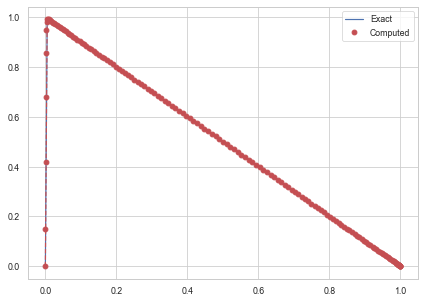

In [57]:
eps_vec = [0.001, 0.01, 0.1]
N = 150

##### Find uhat by solving system #####
z, uhat = Tau_Legendre(a, b, c, g0, gN, N)

Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
x_eval = 1/2 * (z+1)

u_compute = uhat @ Phi

##### Plot #####
x_plot = np.linspace(x0, xN, 200, endpoint=True)
z_plot = 2 * x_plot - 1
Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])

u_plot = uhat @ Phi

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(x_plot, uexact(x_plot, eps), label = "Exact")
ax.plot(x_eval, u_compute, "ro", label = "Computed")
ax.plot(x_plot, u_plot, "r--")
ax.legend()

### Relative differences in accuracy

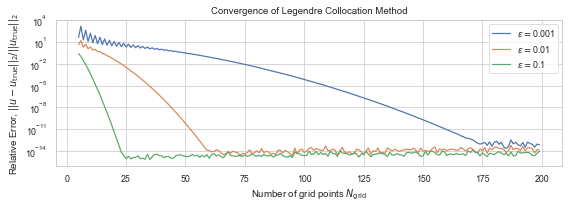

In [58]:
N_grids = np.arange(5, 200, 1, dtype=int)
errors = np.zeros((len(eps_vec), len(N_grids)), dtype=float)

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

for (i, eps) in enumerate(eps_vec):
    a = - 4 * eps
    for (j, N) in enumerate(N_grids):
        z, uhat = Tau_Legendre(a, b, c, g0, gN, N)

        Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
        x_eval = 1/2 * (z+1)

        u_compute = uhat @ Phi

        errors[i, j] = np.linalg.norm(u_compute-uexact(x_eval, eps))

        # u_ex = uexact(x_eval, eps)
        
        # jacobian = (b-a)/2.0

        # errors = u_compute - u_ex
        # absolute_error = np.sqrt(np.sum((errors ** 2) * jacobian * w_gl))
        # norm_true_solution = np.sqrt(np.sum((u_ex ** 2) * jacobian * w_gl))
        # relative_error = absolute_error / norm_true_solution

        # naive_norm_error = np.linalg.norm(u_compute - u_ex, ord=2)

        # data.append({
        #     "N_grid": N_grid,
        #     "epsilon": epsilon,
        #     "naive_norm_error": naive_norm_error,
        #     "relative_error": relative_error,
        # })

    ax.plot(N_grids, errors[i], "-", label=rf"$\varepsilon=${eps}")

ax.set_yscale('log')
ax.legend()
# ax.set_ylabel(r"$\|u-u_{N}\|_2$")
# ax.set_xlabel("N")

# For report
# df = pd.DataFrame(data)
# sns.lineplot(data=df, x="N_grid", y="relative_error", hue="epsilon", palette="tab10")
# plt.semilogy()

ax.set_title("Convergence of Legendre Collocation Method")
ax.set_xlabel("Number of grid points $N_\\text{grid}$")
ax.set_ylabel("Relative Error, $||u - u_{\\mathrm{true}}||_2 / ||u_{\\mathrm{true}}||_2$")
# sns.move_legend(ax, loc="best", title="ε")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_convergence.png", dpi=EXPORT_DPI, bbox_inches='tight')
